# Data refinement for Random forest regressor 🌴🎄

This challenge focuses on briniging different types of feature engineering techniques to improve the prediction accuracy of Static random forest model.

Few things to keep in mind before we dive into solving the challenge :
1. Submission will be provided as an input to a random forest regressor model. Models performance in RMSE is evaluated
2. Submission should contain all columns given in sample_submission.csv
3. Submission should not contain any NaN values
4. Submission can have fewer rows not more rows than sample_submission.csv
5. Dataset is synthetically created using [Dissolved oxygen prediction in river water
](https://www.kaggle.com/datasets/vbmokin/dissolved-oxygen-prediction-in-river-water)

# About the dataset 📊
* Dataset has data of the 5 indicators of river water quality from 8 consecutive stations of the state water monitoring system. 
* Idea is to predict the value in the eighth station by the first seven stations. 
* The numbering of stations in the dataset is done from the target station upstream, ie closest to it - first, upstream - second, etc.
    * For example : O2_7 is the first station in the upstream, because it is fartherest from the target station
* Data are average monthly. The number of observations on stations is different (from 4 to about 20 years).



## River water quality indicators 🌊

* Dissolved oxygen (O2) is measured in mgO2/cub. dm (ie milligrams of oxygen (O2) in the cubic decimeter)
* Ammonium ions (NH4) concentration is measured in mg/cub. dm (ie milligrams in the cubic decimeter)
* Nitrite ions (NO2) concentration is measured in mg/cub. dm (ie milligrams in the cubic decimeter)
* Nitrate ions (NO3) concentration is measured in mg/cub. dm (ie milligrams in the cubic decimeter)
* Biochemical oxygen demand, which is determined in 5 days ("BOD5" or "BOD"). BOD5 is measured in mgO/cub. dm (ie milligrams of oxygen in the cubic decimeter)

The minimum permissible value of O2 in Ukraine is 4 mgO2/cub. dm.
Id - the unique id of a given monthly averaged data;
target - a values of monthly averaged data of O2 in target station, mgO2/cub. dm;
1-7 - a values of monthly averaged data in stations 1-7 (in seven stations located from the target station upstream)

# Lets get started 🥋

In [1]:
# Installing packages
!pip install -q --upgrade PrettyTable pyod 

In [2]:
# Importing libraries
import os
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from prettytable import PrettyTable
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from tabulate import tabulate
from pyod.models.ecod import ECOD

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# Function to analyse descriptive charactersistics of a dataframe
def analyze_dataframe(input_df):
    # Calculate missing value counts and percentages
    missing_values = input_df.isnull().sum()
    missing_percent = (missing_values / len(input_df)) * 100

    # Calculate descriptive statistics
    stats = input_df.describe()

    # Calculate zero counts and percentages
    zero_counts = (input_df == 0).sum()
    zero_percent = (zero_counts / len(input_df)) * 100

    # Calculate negative value counts and percentages
    negative_counts = (input_df < 0).sum()
    negative_percent = (negative_counts / len(input_df)) * 100

    # Create the output DataFrame
    output_data = {
        'Column Name': input_df.columns,
        'Missing Values Count': missing_values,
        'Missing Values Percentage': missing_percent,
        'Mean': stats.loc['mean'],
        'Std Deviation': stats.loc['std'],
        'Min': stats.loc['min'],
        '25th Percentile': stats.loc['25%'],
        '50th Percentile (Median)': stats.loc['50%'],
        '75th Percentile': stats.loc['75%'],
        'Max': stats.loc['max'],
        'Zero Values Count': zero_counts,
        'Zero Values Percentage': zero_percent,
        'Negative Values Count': negative_counts,
        'Negative Values Percentage': negative_percent
    }

    output_df = pd.DataFrame(output_data)
    output_df = output_df.round(2)
    output_df = output_df.drop(['Column Name'], axis=1)
    return output_df

# Function to drop records if the value is less than given thresholds
def drop_records_below_threshold(df, cols, threshold=0):
    filtered_df = df.copy()
    for i in cols:
        filtered_df = filtered_df[filtered_df[i] > threshold]
    return filtered_df

# Function to drop records if the value is greater than given thresholds
def drop_records_above_threshold(df, cols, threshold=0):
    filtered_df = df.copy()
    for i in cols:
        filtered_df = filtered_df[filtered_df[i] < threshold]
    return filtered_df

def plot_box_subplots(data, column_sets, subplot_rows, subplot_cols):
    fig, axes = plt.subplots(subplot_rows, subplot_cols, figsize=(12, 8))
    
    for i, col_set in enumerate(column_sets):
        row = i // subplot_cols
        col = i % subplot_cols
        ax = axes[row, col]
        
        sns.boxplot(data=data[col_set], ax=ax)
        ax.set_title(f'Box Plot for {", ".join(col_set)}', fontdict={'fontsize': 8})
    
        ax.tick_params(axis='x', labelsize=8)
        ax.tick_params(axis='y', labelsize=8)
    
    plt.tight_layout()
    plt.show()

def plot_lineplots_subplots(dataframe, column_sets):
    num_plots = len(column_sets)
    num_cols = 2  # You can adjust the number of columns in the subplot grid
    num_rows = np.ceil(num_plots / num_cols).astype(int)
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
    
    for i, columns in enumerate(column_sets):
        row = i // num_cols
        col = i % num_cols
        ax = axes[row, col]
        
        for col_name in columns:
            sns.lineplot(data=dataframe, x=dataframe.index, y=dataframe[col_name], ax=ax, label=col_name)
            
        ax.set_title(f'Line Plots for {", ".join(columns)}')
        ax.set_xlabel('X Axis')
        ax.set_ylabel('Y Axis')
        ax.legend()
    
    # Hide empty subplots
    for i in range(len(column_sets), num_rows * num_cols):
        fig.delaxes(axes.flatten()[i])
    
    plt.tight_layout()
    plt.show() 
    
def descriptive_stats_table(data):
    mean = np.mean(data)
    median = np.median(data)
    std_dev = np.std(data)
    min_val = np.min(data)
    max_val = np.max(data)
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)

    headers = ["Statistic", "Value"]
    table_data = [
        ["Mean", round(mean,3)],
        ["Median", round(median,3)],
        ["Standard Deviation", round(std_dev,3)],
        ["Minimum", round(min_val,3)],
        ["Maximum", round(max_val,3)],
        ["25th Percentile (Q1)", round(q1,3)],
        ["75th Percentile (Q3)", round(q3,3)]
    ]

    table = tabulate(table_data, headers=headers, tablefmt="pretty")
    print("Descriptive statistics of RMSE :")
    print(table)

def random_forest_regressor_perf(data,cv):
    X = data.drop(["id","target"],axis=1)
    y = data['target']
    rf = RandomForestRegressor(
       n_estimators=1000,
       max_depth=7,
       n_jobs=-1,
       random_state=42)
    return(descriptive_stats_table(np.sqrt(-1 * cross_val_score(rf, X, y, cv = cv, scoring = 'neg_mean_squared_error'))))

In [4]:
river_df = pd.read_csv("/kaggle/input/playground-series-s3e21/sample_submission.csv")

In [5]:
print("Dimension of data :",river_df.shape)

Dimension of data : (3500, 37)


### Model performance Checkpoint 1 - What is the performance of RF regressor on raw input file ?

In [6]:
random_forest_regressor_perf(river_df,5)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Descriptive statistics of RMSE :
+----------------------+-------+
|      Statistic       | Value |
+----------------------+-------+
|         Mean         | 1.399 |
|        Median        | 1.158 |
|  Standard Deviation  | 0.61  |
|       Minimum        | 1.018 |
|       Maximum        | 2.611 |
| 25th Percentile (Q1) | 1.019 |
| 75th Percentile (Q3) | 1.191 |
+----------------------+-------+


Going forward, our objective is to do trial and error using various techniques to reduce the above statistics.

# Data exploration 🔍

In [7]:
river_df.head()

,id,target,O2_1,O2_2,O2_3,O2_4,O2_5,O2_6,O2_7,NH4_1,...,NO3_5,NO3_6,NO3_7,BOD5_1,BOD5_2,BOD5_3,BOD5_4,BOD5_5,BOD5_6,BOD5_7
0,0,8.59,7.500,9.00,9.545,9.265,8.110,8.43,7.15,0.180,...,4.95,1.730,1.800,4.800,3.15,10.665,10.465,16.645,5.75,10.37
1,1,9.10,13.533,40.90,8.770,9.265,6.015,10.07,7.15,1.107,...,20.05,9.530,7.695,4.550,6.95,2.040,5.200,5.725,2.95,2.23
2,2,8.21,3.710,5.42,8.770,9.265,4.550,10.07,7.15,0.020,...,4.58,3.025,3.960,4.935,4.95,4.725,6.075,6.750,3.50,3.17
3,3,8.39,8.700,8.10,9.500,9.200,5.200,8.67,6.67,0.280,...,8.45,2.070,1.730,6.300,4.70,3.500,6.200,8.670,2.90,7.37
4,4,8.07,8.050,8.65,7.960,9.265,3.290,10.07,7.15,0.360,...,2.02,1.730,0.760,4.800,4.97,3.950,2.800,8.400,3.50,3.90


In [8]:
analyze_dataframe(river_df)

,Missing Values Count,Missing Values Percentage,Mean,Std Deviation,Min,25th Percentile,50th Percentile (Median),75th Percentile,Max,Zero Values Count,Zero Values Percentage,Negative Values Count,Negative Values Percentage
id,0,0.0,1749.50,1010.51,0.00,874.75,1749.50,2624.25,3499.00,1,0.03,0,0.00
target,0,0.0,8.47,1.89,1.30,7.47,8.28,9.11,65.93,0,0.00,0,0.00
O2_1,0,0.0,8.22,3.04,0.00,7.10,7.89,9.10,46.95,1,0.03,0,0.00
O2_2,0,0.0,9.29,6.82,0.00,7.30,8.30,8.70,65.95,1,0.03,0,0.00
O2_3,0,0.0,9.63,1.44,4.90,8.77,9.50,9.54,16.90,0,0.00,0,0.00
O2_4,0,0.0,8.07,1.46,2.30,6.83,7.98,9.26,21.80,0,0.00,0,0.00
O2_5,0,0.0,5.67,2.72,0.20,4.55,5.80,7.02,59.40,0,0.00,0,0.00
O2_6,0,0.0,9.46,1.14,0.00,8.98,9.43,10.07,40.19,3,0.09,0,0.00
O2_7,0,0.0,6.55,1.66,0.00,5.88,6.43,7.15,15.90,2,0.06,0,0.00
NH4_1,0,0.0,0.34,0.28,0.02,0.21,0.25,0.37,4.20,0,0.00,0,0.00


Observation: 
* Presence of 0mg/cub of Oxygen,Ammonium, Nitrite (NO2) and nitrate (NO3) is observed in the data. In real life cases, all four indicators are required to maintain stable aquatic ecosystem
* Negative value in NO2 at station 4 is observed
* NH4 at station 5 have higher mg/cub compared to other stations
    * Possible reasons : Station is near where industries/city discharges its waste to river
    * We can validate using correlation of Ammonium with other indicators in other stations

We can remove observations with zero or negative values in data cleaning phase
To check number of obervations where O2 Indicator < 4mg/cub (Permissible limit in Ukraine)

In [9]:
# Number of observations with O2 below permissalble levels
condition_O2 = (river_df.O2_1<4) | (river_df.O2_2<4) |(river_df.O2_3<4) |(river_df.O2_4<4) |(river_df.O2_5<4) |(river_df.O2_6<4) |(river_df.O2_7<4) 
print("Total number of obervations where O2 indicator is below threshold :",sum(condition_O2))
print("Records impacted :",(sum(condition_O2)/len(river_df))*100,"%")

Total number of obervations where O2 indicator is below threshold : 882
Records impacted : 25.2 %


Observation:
882 observations (25.2%) have O2 level below required threshold.

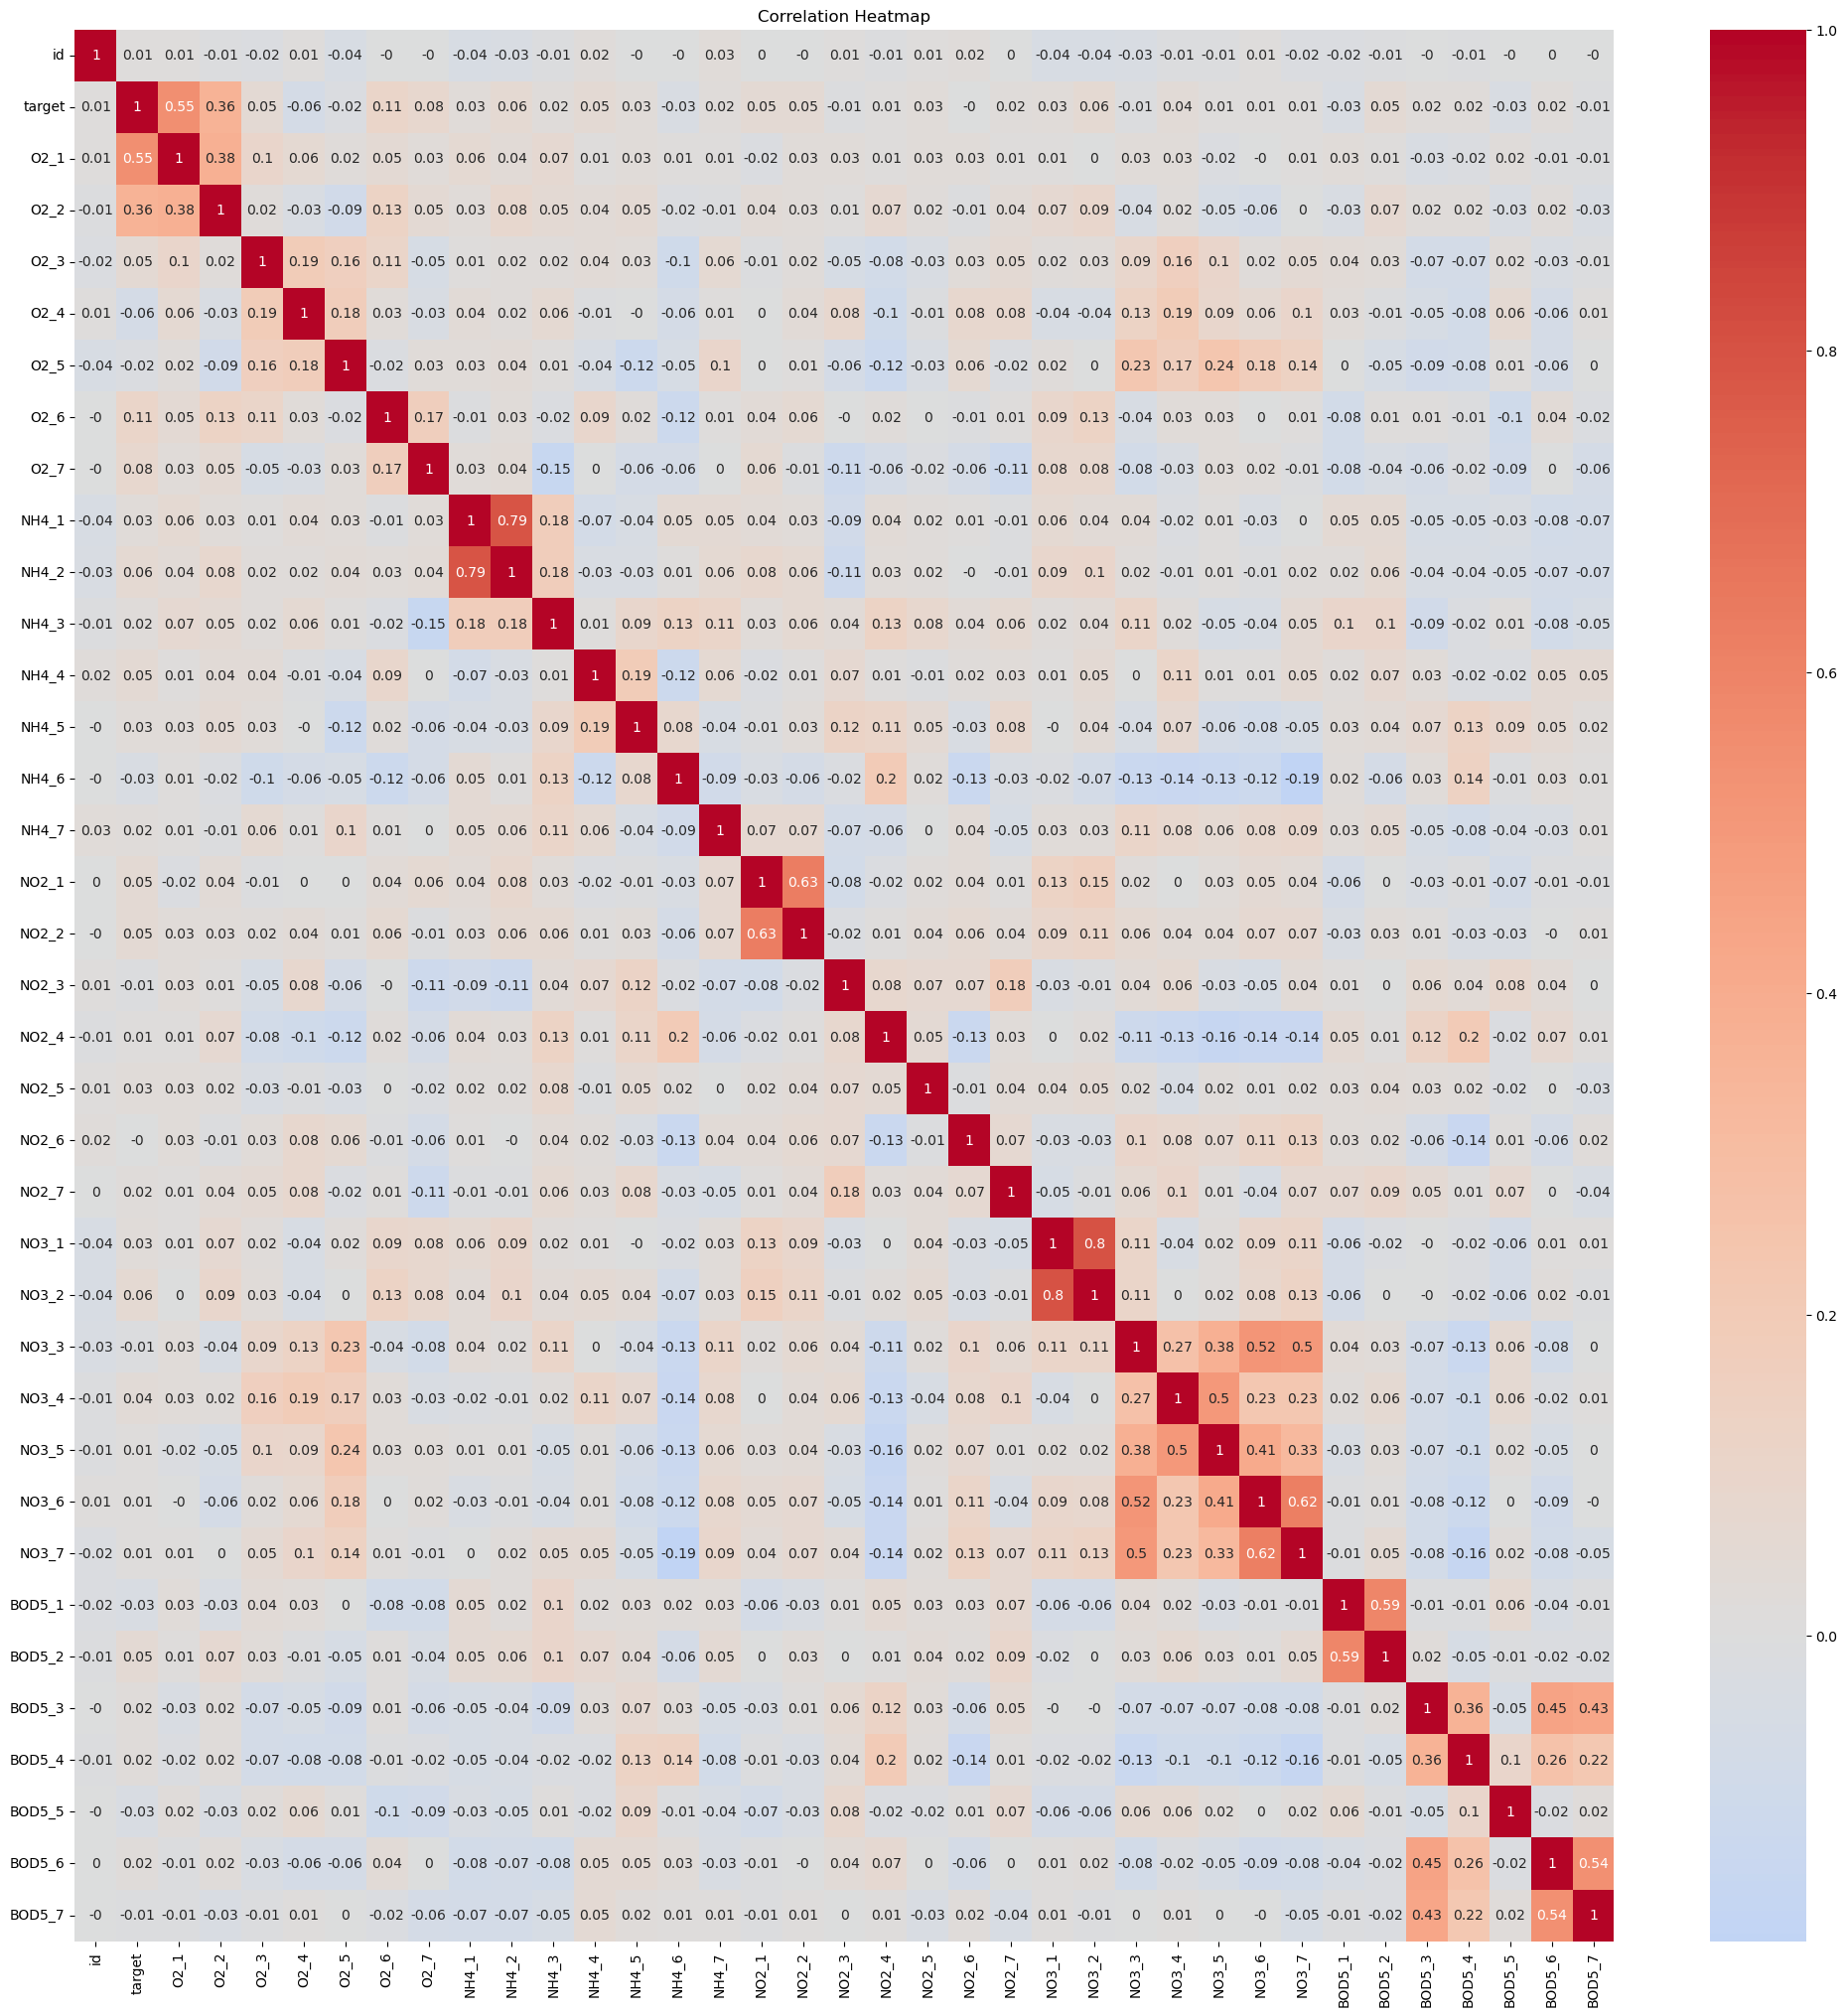

In [10]:
# Calculate correlation matrix
# Spearman correlation is used to check monotonic relationships
correlation_matrix = round(river_df.corr(method="spearman"),2)

# Create a heatmap using seaborn
plt.figure(figsize=(25, 25))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.show()

Observations:
* NO3 and BOD indicators from station n is dependent on previous station n-1
* Target variable is moderetly correlated with O2_1

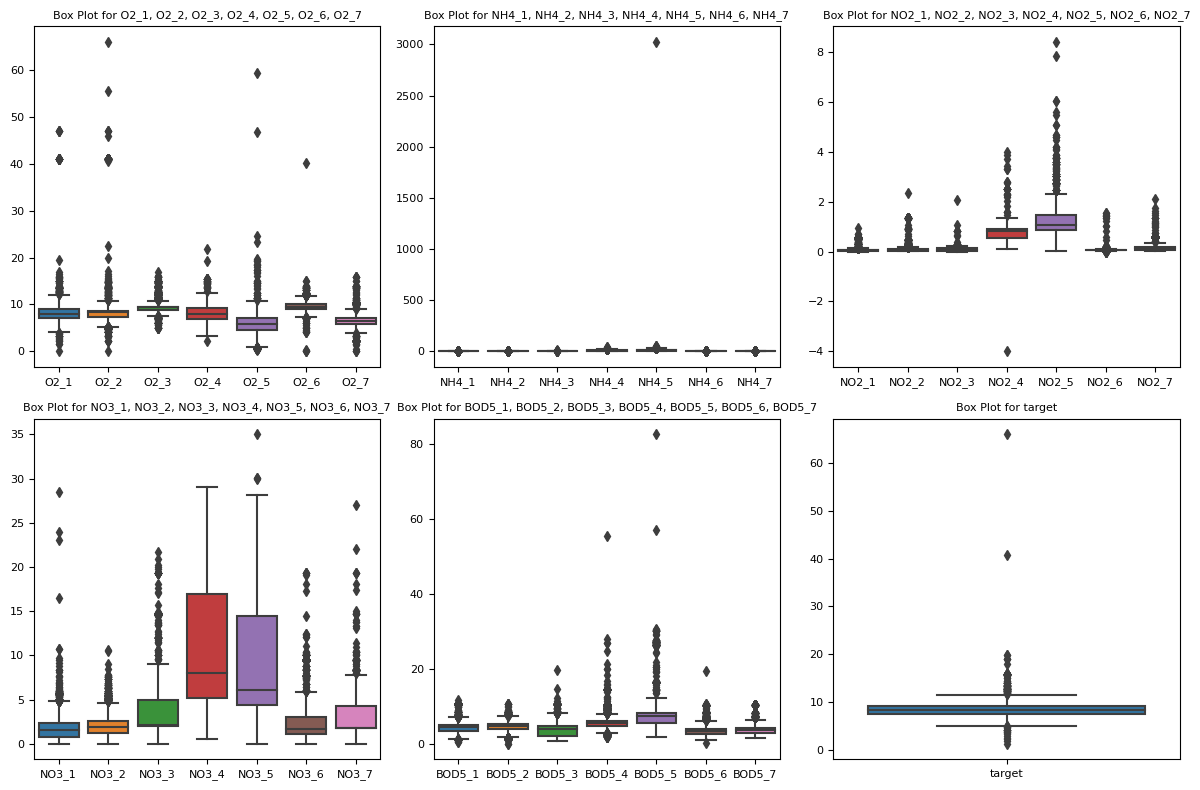

In [11]:
column_sets = [['O2_1', 'O2_2', 'O2_3', 'O2_4', 'O2_5', 'O2_6', 'O2_7'], 
               ['NH4_1', 'NH4_2', 'NH4_3', 'NH4_4', 'NH4_5', 'NH4_6', 'NH4_7'], 
               ['NO2_1', 'NO2_2', 'NO2_3', 'NO2_4', 'NO2_5', 'NO2_6', 'NO2_7'],
               ['NO3_1', 'NO3_2', 'NO3_3', 'NO3_4', 'NO3_5', 'NO3_6', 'NO3_7'],
               ['BOD5_1', 'BOD5_2','BOD5_3', 'BOD5_4', 'BOD5_5', 'BOD5_6', 'BOD5_7'],
               ['target']]
plot_box_subplots(river_df,column_sets,2,3)

Observations:
* Extreme outlier in NH4_5 is identified
* IQR of NO3_4 and NO3_5 is wider than NO3 observed in other stations
* IQR of NO2_4 and NO2_5 is slightly wider than NO2 obeserved in other stations

Removing obeservations at indicator level which are extreme data points in the data cleaning step:
* O2 > 30mg/Cub
* NH4 > 2500mg/Cub
* NO2 > 6mg/Cub
* NO3 > 25mg/Cub
* BOD > 50mg/Cub
* Target > 40mg/Cub

# Data cleaning 🧹

In [12]:
# Removing observations with Zero and Negative values in target and predictor variables
cols_to_treat_zero_n_neg = [col for col in river_df.columns if col not in ['id']]
treated_river_df = drop_records_below_threshold(river_df,cols_to_treat_zero_n_neg,threshold=0)

# analyze_dataframe(treated_river_df)
print("Dimension of data after removing Zero's and Negative values :",treated_river_df.shape)

Dimension of data after removing Zero's and Negative values : (3471, 37)


## Outlier removal - Feature level

In [13]:
# Removing observations with extreme values in predictor and target variable
treated_river_df = drop_records_above_threshold(treated_river_df,['O2_1', 'O2_2', 'O2_3', 'O2_4', 'O2_5', 'O2_6', 'O2_7'],30)
treated_river_df = drop_records_above_threshold(treated_river_df,['NH4_1', 'NH4_2', 'NH4_3', 'NH4_4', 'NH4_5', 'NH4_6', 'NH4_7'],2500)
treated_river_df = drop_records_above_threshold(treated_river_df,['NO2_1', 'NO2_2', 'NO2_3', 'NO2_4', 'NO2_5', 'NO2_6', 'NO2_7'],6)
treated_river_df = drop_records_above_threshold(treated_river_df,['NO3_1', 'NO3_2', 'NO3_3', 'NO3_4', 'NO3_5', 'NO3_6', 'NO3_7'],25)
treated_river_df = drop_records_above_threshold(treated_river_df,['BOD5_1', 'BOD5_2','BOD5_3', 'BOD5_4', 'BOD5_5', 'BOD5_6', 'BOD5_7'],50)
treated_river_df = drop_records_above_threshold(treated_river_df,['target'],40)


# analyze_dataframe(treated_river_df)
print("Dimension of data after removing observations with extreme values in Predictor and target variable :",treated_river_df.shape)

Dimension of data after removing observations with extreme values in Predictor and target variable : (3300, 37)


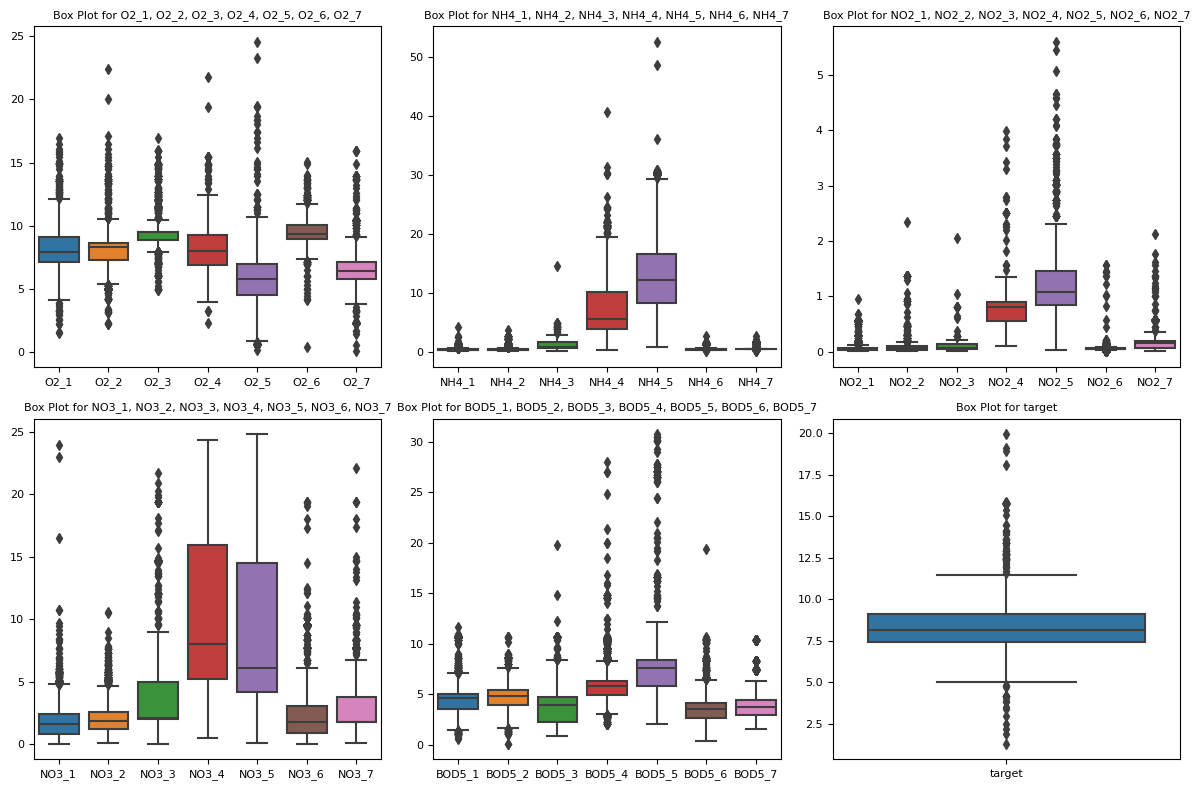

In [14]:
column_sets = [['O2_1', 'O2_2', 'O2_3', 'O2_4', 'O2_5', 'O2_6', 'O2_7'], 
               ['NH4_1', 'NH4_2', 'NH4_3', 'NH4_4', 'NH4_5', 'NH4_6', 'NH4_7'], 
               ['NO2_1', 'NO2_2', 'NO2_3', 'NO2_4', 'NO2_5', 'NO2_6', 'NO2_7'],
               ['NO3_1', 'NO3_2', 'NO3_3', 'NO3_4', 'NO3_5', 'NO3_6', 'NO3_7'],
               ['BOD5_1', 'BOD5_2','BOD5_3', 'BOD5_4', 'BOD5_5', 'BOD5_6', 'BOD5_7'],
               ['target']]
plot_box_subplots(treated_river_df,column_sets,2,3)

Observations : 
* 200 obervations removed due to presence of values <=0 and outliers

Addressing the presence of outliers : 
* From the box plots, we can observe the presence of outliers at feature level,we will try to identify outliers at observations level.
* Due to presence of high dimensionality, will use dimensionality reduction techniques, outlier detection techniques to identify observations which deviates from the majority.

### Model performance Checkpoint 2 - What is the performance of RF regressor after removal of feature level outliers ?

In [15]:
random_forest_regressor_perf(treated_river_df,5)

Descriptive statistics of RMSE :
+----------------------+-------+
|      Statistic       | Value |
+----------------------+-------+
|         Mean         | 1.043 |
|        Median        | 1.029 |
|  Standard Deviation  | 0.033 |
|       Minimum        |  1.0  |
|       Maximum        | 1.082 |
| 25th Percentile (Q1) | 1.024 |
| 75th Percentile (Q3) | 1.08  |
+----------------------+-------+


In [16]:
treated_river_df.to_csv("/kaggle/working/submission.csv",index=False)

## Outlier detection - Observation level

In [17]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD

# Create the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svd', TruncatedSVD(n_components=2))
])

# Fit and transform the pipeline on your data
pc_df = pipeline.fit_transform(treated_river_df.drop(['id','target'],axis=1))

pc_df = pd.DataFrame(pc_df,columns=['PC1', 'PC2'])

In [18]:
fig = px.scatter(pc_df, x='PC1', y='PC2')
fig.show()

## Cluster analysis
Idea is to identify the clusters in the data, so that we can oversample/undersample the observations

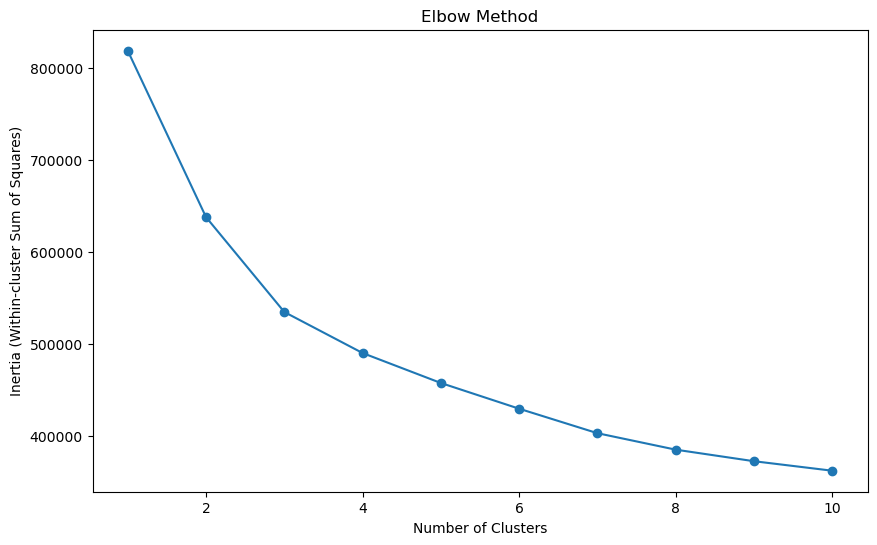

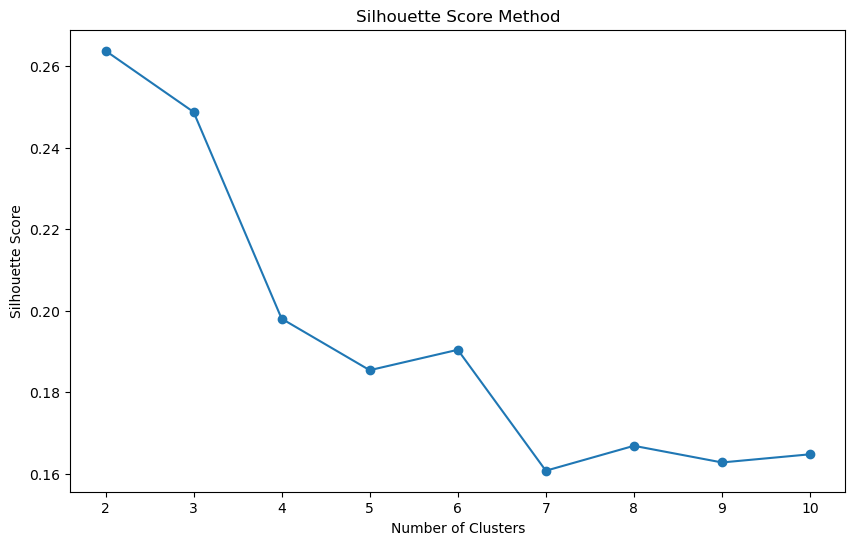

In [19]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Elbow Method
inertia_values = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42,n_init = 10)
    kmeans.fit(treated_river_df.drop(['id','target'],axis=1))
    inertia_values.append(kmeans.inertia_)

# Plot Elbow Method graph
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertia_values, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia (Within-cluster Sum of Squares)')
plt.title('Elbow Method')
plt.show()

# Silhouette Score
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42,n_init = 10)
    kmeans.fit(treated_river_df.drop(['id','target'],axis=1))
    labels = kmeans.labels_
    score = silhouette_score(treated_river_df.drop(['id','target'],axis=1), labels)
    silhouette_scores.append(score)

# Plot Silhouette Score graph
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Method')
plt.show()